<img style="float: left;" src="../earth-lab-logo-rgb.png" width="150" height="150">

# Earth Data Science Corps Summer 2020

![Colored Bar](../colored-bar.png)


<div class='notice--success' markdown="1">

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Challenge: Plot Different Types of Spatial Data Using Open Source Python

Throughout these chapters, you've learned a lot on how to plot many different types of data. You've used a combination of multiple libraries to plot data, including **pandas**, **geopandas**, **matplotlib**, **earthpy**, and various others. This challenge will challenge you to use the appropriate packages and tools to plot each type of data that have been covered so far. First, you will plot out various forms of vector data, then raster data, and finally you will plot a combination of the raster and vector data. 
</div>

In [1]:
# Import Packages

import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent
import folium
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es

import warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

# Add seaborn general plot specifications
sns.set(font_scale=1.5, style="whitegrid")

<div class="notice--warning" markdown="1">

## <i class="fa fa-pencil-square-o" aria-hidden="true"></i> Challenge 1: Create a Map Of RMNP Trails for the South Zone of the Park

The first plot you are going to make is a vector plot that displays 
hiking trails in Rocky Mountain National Park (RMNP) - which is located in Colorado. 

To make this plot, do the following: 

1. Read in the trails, trailsheads and ranger zones data for the Rocky Mountain National Park trails and the National Parks Service boundaries. The code to open the data is in the cell below for you to run.
2. Create a new GeoDataFrame that only contains the South Zone of the RMNP ranger zones `ranger_zones[ranger_zones["SUBDISTRIC"] == "SOUTH"]` data  for the park.
3. Change the Coordinate Reference System of the boundary dataset to match the trails dataset. To get the Coordinate Reference System of the trails dataset, you can use `trails_dataframe_name.crs`. To set it to the boundary dataset, you can use the `to_crs()` function like so: `boundary_dataframe_name.to_crs(trails_dataframe_name.crs)`
4. Plot the trails data and the trailheads data together in a map. 
5. Add the polygon boundary of the South Ranger zone to the map. 
6. Change the symbology for the lines and points on the map. For lines, you will change the `linestyle=` argument [options for this argument here](https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/linestyles.html) and for points you will modify the `marker=` arguement [options for this argument here](https://matplotlib.org/api/markers_api.html).
7. We want a legend for this map, to show the symbology of trails and trail heads. To create this, in the plotting functions for your GeoDataFrames, add an argument `label=` and set it to what you want to call the trails and trailheads on your maps. Also, make sure you have the following lines of code in your plot. It will grab the labels you set in the plot functions and add them to the legend. 
```
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
```
8. Add a title to your plot. 

</div>

****

<div class='notice--success alert alert-info' markdown="1">

<i class="fa fa-star"></i> **Data Tip:** For help with this challenge, see your previous activities involving vector plotting, [this chapter explaining reprojecting data into a new CRS](https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/) from the EarthLab website, or [this chapter covering vector and legend plotting](https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-vector-plots/python-customize-map-legends-geopandas/). 

</div>

In [2]:
# Open RMNP Boundary -- we might not need this
# RMNP Boundary Layer: Lat lon 4326 -- direct download
rmnp_boundary = gpd.read_file(
    "https://opendata.arcgis.com/datasets/7cb5f22df8c44900a9f6632adb5f96a5_0.geojson")

In [3]:
# Trails are UTM Zone 13N --  reproject to lat long
rmnp_trails = gpd.read_file(
    "https://opendata.arcgis.com/datasets/e1e0bcb87eb94960bc04f76e03936385_0.geojson")
rmnp_trails_4326 = rmnp_trails.to_crs(rmnp_boundary.crs)

In [4]:
# Open ranger zones  - EPSG 4326
ranger_zones = gpd.read_file(
    "https://opendata.arcgis.com/datasets/fdffd3272ba546da9176416b814d2e8f_0.geojson")

# Trailheads - 4326
trailheads = gpd.read_file(
    "https://opendata.arcgis.com/datasets/55748f2f1d8a4db7aa26f7549e74be57_0.geojson")

In [5]:
# Subset trails to include only trails for ranger subdistrict SOUTH
south_zone = ranger_zones[ranger_zones["SUBDISTRIC"] == "SOUTH"]

# Clip the trails and trailheads data
trails_south = gpd.clip(rmnp_trails_4326, south_zone)
trailheads_south = gpd.clip(trailheads, south_zone)

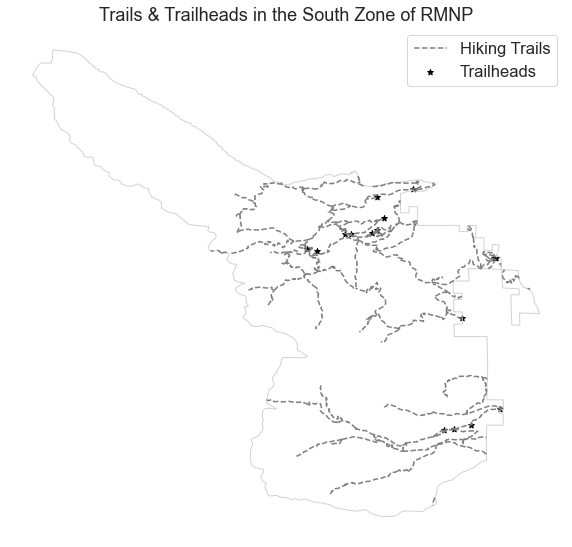

In [6]:
# Plot the trail data

fig, ax = plt.subplots(figsize=(10, 10))

trails_south.plot(ax=ax,
                  color="Grey",
                  linestyles='--',
                  label="Hiking Trails")

trailheads_south.plot(ax=ax,
                      label="Trailheads",
                      marker="*",
                      color="black")

south_zone.plot(ax=ax,
                edgecolor="lightgrey",
                color="None")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)


ax.set(title="Trails & Trailheads in the South Zone of RMNP")
ax.set_axis_off()
plt.show()

<div class="notice--warning" markdown="1">

## <i class="fa fa-pencil-square-o" aria-hidden="true"></i> Challenge 2: Overlay a Terrain Model on top of a Hillshade  

Next you will create a base map to put your trails on. In order to do this, you will use a Digital Elevation Model (`USGS_1_n41w106.tif`) for RMNP. The code to download the DEM is in the cell below. Once that is downloaded, you must complete the following steps to create the hillshade and plot the two rasters on top of each other. 

1. Read in the USGS DEM into a numpy array using rasterio. 
2. Clip the data to the extent of the south zone boundary you plotted earlier using this syntax inside of the context manager you used to open the array: 
```clipped_data, clipped_metadata = es.crop_image(rasterio_variable_name, south_zone_geodataframe_variable_name)```
3. Create a hillshade from the clipped DEM using the syntax: `es.hillshade(dem-numpy-array-name-here)`. This function outputs a numpy array with the hillshade data.
4. Overlay the clipped DEM array on top of the hillshade array you just created. 
5. Be sure to add a title to your plot.

</div>

*****

<div class='notice--success alert alert-info' markdown="1">

<i class="fa fa-star"></i> **Data Note:** The data for this challenge was acquired through the [National Map](https://viewer.nationalmap.gov/basic/), a website that the U.S. Geological Survey uses to distribute data. This data is a DEM with 30 Meter resolution, which is to say that every pixel of the image represents a 30 by 30 meter square on the ground. 

</div>

*****

<div class='notice--success alert alert-info' markdown="1">

<i class="fa fa-star"></i> **Data Tip:** For help with this challenge, please see [this chapter](https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-raster-plots/) on the EarthLab website covering raster data plots, as well as your previous lessons on plotting raster data. 

</div>

In [7]:
# All these data are 4326 so reprojecting to that above makes sense
et.data.get_data(url="https://ndownloader.figshare.com/files/23399609")
os.chdir(os.path.join(et.io.HOME, "earth-analytics", "data"))
ned_30m_path = os.path.join("earthpy-downloads", "USGS_1_n41w106.tif")

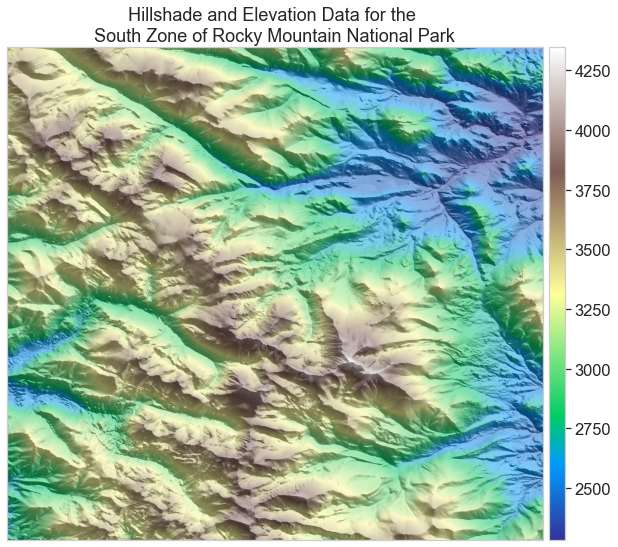

In [8]:
# open the data
with rio.open(ned_30m_path) as ned_src:
    ned = ned_src.read(1)
    # crop data to the extent of the south zone
    clipped_data, clipped_metadata = es.crop_image(ned_src, south_zone)

# Create to hillshade
ned_30_hill = es.hillshade(clipped_data[0])

# Plot the data
f, ax1 = plt.subplots(figsize=(10, 10))

ep.plot_bands(clipped_data,
              ax=ax1,
              cmap="terrain")

ep.plot_bands(ned_30_hill,
              ax=ax1,
              cbar=False,
              alpha=.5,
              title="Hillshade and Elevation Data for the \nSouth Zone of Rocky Mountain National Park")

plt.show()

<div class="notice--warning" markdown="1">

## <i class="fa fa-pencil-square-o" aria-hidden="true"></i> Challenge 3: Overlay Trails on top of Elevation Data.

Next you will overlay the trails data on top of the elevation data that you plotted above.
Keep in mind a few things when you do this

1. You will need to create a plotting_extent object to use in the `extent=` plot parameter in `ep.plot_bands()` to ensure that your raster data line up with the vector data. Make sure you use the data and metadata that was the output of your clip to create the plotting_extent object so that the extent is correct. Your code should look like the following: 
```
ned_cl_extent = plotting_extent(clipped_data[0], clipped_metadata["transform"])
```
2. The legibility of data will change with the background data, so be sure to adjust colors/thickness of your data if you need to in order to make it visible. 
3. Be sure to add a title to your map. 

</div>

******
<div class='notice--success alert alert-info' markdown="1">

<i class="fa fa-star"></i> **Data Tip:** For help with this challenge, please see [this chapter](https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-raster-plots/plotting-extents/) on the EarthLab website covering plotting extents and overlaying datatypes. 
</div>

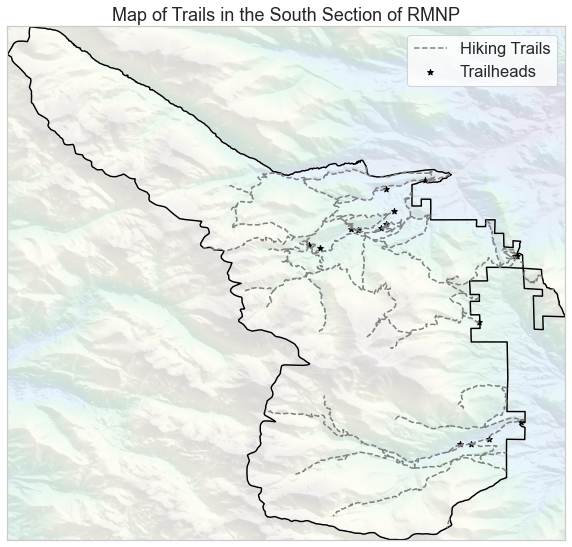

In [9]:
# plot

ned_cl_extent = plotting_extent(clipped_data[0], clipped_metadata["transform"])


f, ax = plt.subplots(figsize=(10, 10))
south_zone.plot(ax=ax,
                color="None",
                linewidth=2)

ep.plot_bands(clipped_data,
              ax=ax,
              cmap="terrain",
              extent=ned_cl_extent,
              alpha=.1,
              cbar=False)

ep.plot_bands(ned_30_hill,
              ax=ax,
              cbar=False,
              alpha=.1,
              extent=ned_cl_extent)

trails_south.plot(ax=ax,
                  color="Grey",
                  linestyles='--',
                  label="Hiking Trails")

trailheads_south.plot(ax=ax,
                      marker="*",
                      color="black",
                      label="Trailheads")

south_zone.plot(ax=ax,
                edgecolor="black",
                color="None",
                linewidth=1.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set(title="Map of Trails in the South Section of RMNP")
plt.show()

<div class="notice--warning" markdown="1">

## <i class="fa fa-pencil-square-o" aria-hidden="true"></i> Challenge 4: OPTIONAL Plot Interactive Vector Data

Below is a map that was made with **folium** to create an interactive map of the trails and trailheads in Rocky Mountain National Park. This is another way to give your data a background to give it context, besides using elevation or imagery data. Notice you can zoom in/out and move around the map by clicking and dragging. However, there are some aspects that you can change to make the map better! Here are some improvements you can give to the map: 

1. You can see where the lines are assigned colors with the `style` dictionary. Change the color to an easier color to see, as the green blends in with the background. 
2. The play icon is a nice marker for trailheads, but not the only option. Change the `icon=` argument in `folium.Icon()` to be another shape. There's a list of [usable icons here](https://fontawesome.com/icons?d=gallery). Note: Not all of the icons on that site will work, so if you pick one and it doesn't display try a different option!
3. When you click on the trailhead points, you will see it displays the `GEOMETRYID` value for the point. It may be more useful to display the `POINAME` column, which has the trail name stored in it. Change the column to the correct name so it displays properly. 
4. You may notice that the map initially starts really zoomed out. Change the `zoom_start` to make the map start close to the coverage of the data. 
</div>

*********

<div class='notice--success alert alert-info' markdown="1">

<i class="fa fa-star"></i> **Data Tip:** For help with this challenge, please see [this chapter](https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-vector-plots/interactive-leaflet-maps-in-python-folium/) on the EarthLab website covering interactive maps, and [this chapter](https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-raster-plots/interactive-maps/) covering a similar topic. 
</div>

In [10]:
# Style Dictionary
style = {'color': 'green'}

# Adding the lines to the map
trails_south_json = trails_south.to_json()
interactive_map = folium.Map(location=[40.37244, -105.66472], zoom_start=7)
lines = folium.features.GeoJson(
    trails_south_json, style_function=lambda x: style)
interactive_map.add_child(lines)

# Adding the points to the map
for i in range(len(trailheads_south)):
    folium.Marker([trailheads_south.iloc[i].geometry.y, trailheads_south.iloc[i].geometry.x],
                  popup=trailheads_south.iloc[i]['GEOMETRYID'], icon=folium.Icon(icon='play')).add_to(interactive_map)
interactive_map